In [29]:
#18 cells

#basics for python
import numpy as np
import pandas as pd
from datetime import date, timedelta

#machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score

#model evaluation
from sklearn.metrics import confusion_matrix

#html processing
import requests as rq
from bs4 import BeautifulSoup as bs
import re #regular expressions
import calendar as cal
from datetime import date, datetime

#visualization
import matplotlib.pyplot as plt

In [5]:
# initializing date list
start_date = date(2024, 3, 28)
yesterday = date.today() - timedelta(days=1)
delta = (date.today() - start_date) #using "today" to make the dates work out right
season_end = '20240928'

if int(yesterday.strftime('%Y%m%d')) < int(season_end):
    date_generated = pd.date_range(start_date, periods=delta.days, freq = '1D')
    string_dates = date_generated.strftime('%Y%m%d')

#regular season ends september 29
print('string dates =', string_dates)

string dates = Index(['20240328', '20240329', '20240330', '20240331', '20240401', '20240402',
       '20240403', '20240404', '20240405', '20240406', '20240407', '20240408',
       '20240409', '20240410', '20240411', '20240412', '20240413', '20240414',
       '20240415', '20240416', '20240417', '20240418', '20240419', '20240420',
       '20240421', '20240422', '20240423', '20240424', '20240425', '20240426',
       '20240427', '20240428', '20240429', '20240430', '20240501', '20240502',
       '20240503', '20240504', '20240505', '20240506', '20240507', '20240508',
       '20240509', '20240510', '20240511', '20240512', '20240513', '20240514',
       '20240515', '20240516', '20240517', '20240518', '20240519', '20240520',
       '20240521', '20240522', '20240523', '20240524', '20240525', '20240526',
       '20240527', '20240528', '20240529', '20240530', '20240531', '20240601',
       '20240602', '20240603', '20240604', '20240605', '20240606', '20240607',
       '20240608', '20240609', '20240

In [6]:
#Set up the DF for the scraped data
game_cols = ['Year'
             , 'Month'
             , 'Day of Month'
             , 'Day of Week'
             #game time could be useful, but I'll only have it if I have been tracking since the beginning
             , 'Home Team'
             , 'Away Team'
             , 'Home team home wins'
             , 'Home team away wins'
             , 'Home team home losses'
             , 'Home team away losses'
             , 'Away team home wins'
             , 'Away team away wins'
             , 'Away team home losses'
             , 'Away team away losses'  
             , 'Home team overall wins'
             , 'Home team overall losses'
             , 'Away team overall wins'
             , 'Away team overall losses'
             , 'Home team overall runs for'
             , 'Home team home runs for'
             , 'Home team away runs for'
             , 'Home team overall runs against'
             , 'Home team home runs against'
             , 'Home team away runs against'
             , 'Away team overall runs for'
             , 'Away team home runs for'
             , 'Away team away runs for'
             , 'Away team overall runs against'
             , 'Away team home runs against'
             , 'Away team away runs against'
             , 'Home team overall runs diff'
             , 'Home team home runs diff'
             , 'Home team away runs diff'
             , 'Away team overall runs diff'
             , 'Away team home runs diff'
             , 'Away team away runs diff'
             
             , 'Home_Win_Flag' #This is a binary. I don't need an "away win" flag.
            ]

game_data = pd.DataFrame(columns = game_cols)
game_data.loc[0] = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [7]:
print(game_data.shape)
print(game_data.head())

(1, 37)
   Year  Month  Day of Month  Day of Week  Home Team  Away Team  \
0     0      0             0            0          0          0   

   Home team home wins  Home team away wins  Home team home losses  \
0                    0                    0                      0   

   Home team away losses  ...  Away team overall runs against  \
0                      0  ...                               0   

   Away team home runs against  Away team away runs against  \
0                            0                            0   

   Home team overall runs diff  Home team home runs diff  \
0                            0                         0   

   Home team away runs diff  Away team overall runs diff  \
0                         0                            0   

   Away team home runs diff  Away team away runs diff  Home_Win_Flag  
0                         0                         0              0  

[1 rows x 37 columns]


In [8]:
#initialize everything
team_dict = {}
outer_break = False
index = 0 #where to start adding to the DF

#Initialize first level of records dictionary
#cat0 will be the team
def initiate_numbers_dict():
    numbers_dict = {}
    for cat1 in ['overall', 'home', 'away']:#where played    numbers_dict[cat1] = {}
        numbers_dict[cat1] = {}
        for cat2 in ['record', 'runs']: #kind of stat
            numbers_dict[cat1][cat2] = {}
            for cat3 in ['good', 'bad']: #win/loss or for/against
                numbers_dict[cat1][cat2][cat3] = 0
    return numbers_dict

In [9]:
#month conversion
    #counts starting at Janary = 1
month_name_to_num = {name: num for num, name in enumerate(cal.month_name) if num}
print(month_name_to_num)

#day_of_week_conversion
    #counts starting at Sunday = 1
day_name_to_num = {name: ((num+1) % 7)+1 for num, name in enumerate(cal.day_name)}
print(day_name_to_num)

{'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
{'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7, 'Sunday': 1}


In [10]:
#SCRAPE THE DATA
#also, could include record against opposing team
    #wins vs opponent
    #losses vs opponent
    #with 30 teams in the league that could lead to 30*30*2 = 1800 more columns
    #team pitching stats
    #team hitting stats
    #starter pitching stats
    #Starting position player hitting stats
#I think that a large issue is that I'm assuming that the W/L records and run scored values are present as predictors for each game
#but the only values that I know going into the game are the values before the game is played (after the game prior)
#so what I'm going to try is to put the stats on line i and the Home Win Flag on line i-1
#that way the stats known on date i are predicting the outcome of the game on the next day
for day in string_dates:

    outer_break = False
    if outer_break: #this is set to True if the game has not been played yet.
        break #don't want to keep trying to process if no more games
        
    test_url = "https://www.espn.com/mlb/schedule/_/date/" + day

    #set the header so that espn doesn't reject me directly
    header = {"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36"} #have to do this or else ESPN will block me for being a python script and not a user.
    request = rq.get(test_url, headers = header) #assign my request to a variable

    #get the html of the page
    html_text = bs(request.text, 'html') #See the HTML code of the whole page

    #get the individual responsive tables on the page. These are the three days. I only want the first one.
    responsive_table = html_text.find('div', class_ = "ResponsiveTable")
    table_date = responsive_table.find('div', class_ = "Table__Title").text
    day_of_week_name, nothing1, month_name, day_num, nothing2, year_num, nothing3 = re.split(r'[,| ]', table_date)
    day_of_week_num = int(day_name_to_num[day_of_week_name])
    month_of_year_num = int(month_name_to_num[month_name])
    games = responsive_table.find_all('tr', class_ = 'Table__TR Table__TR--sm Table__even')
    
    for game in games:
        #Get away team
        away_cell = game.find('td', class_ = 'events__col Table__TD')
        away_team = away_cell.find('span', {'class': 'Table__Team away'})
        away_team_tag = away_team.find('a', class_ = 'AnchorLink', tabindex = '0', href = re.compile('/mlb/team/_/name/'))
        away_team_tag_href = away_team_tag.get('href')
        split = re.split('/', away_team_tag_href)
        away_team = split[5].upper()

        #Get home team
        home_cell = game.find('td', class_ = 'colspan__col Table__TD')
        home_team = home_cell.find('span', {'class': 'Table__Team'})
        home_team_tag = home_team.find('a', class_ = 'AnchorLink', tabindex = '0', href = re.compile('/mlb/team/_/name/'))
        home_team_tag_href = home_team_tag.get('href')
        split = re.split('/', home_team_tag_href)
        home_team = split[5].upper()

        #Parse the box score
        game_results = game.find_all('td', class_ = 'teams__col Table__TD')
        score_line = game_results[0].find('a', class_ = 'AnchorLink').text
        if len(re.split(r'[,| ]', score_line)) == 5:
            win_team, win_score, nothing1, lose_team, lose_score = re.split(r'[,| ]', score_line)
        elif len(re.split(r'[,| ]', score_line)) == 6:
            win_team, win_score, nothing1, lose_team, lose_score, extra = re.split(r'[,| ]', score_line)
        else: #Postponed
            continue

        #turn the scores into numbers so I can do calcs with them
        win_score = int(win_score)
        lose_score = int(lose_score)

        #if the team doesn't exist in the dict then create it
        if win_team not in team_dict.keys():
            team_dict[win_team] = initiate_numbers_dict()
        if lose_team not in team_dict.keys():
            team_dict[lose_team] = initiate_numbers_dict()
        
        #i think that knowing home vs away winner will be important to the analysis
        home_win_flag = 0 #default
        #if the home team wins then change the flag to 1
        if win_team == home_team:
            home_win_flag = 1

        #update the records and run numbers
        #there's an error here.
            #20240604 games show a game with 
                #80 home wins, 
                #0 away wins, 
                #0 home losses,
                #40 away losses
                #40 overall wins
                #20 overall losses
        team_dict[win_team]['overall']['record']['good'] += 1 #overall record for the home team gets a win
        team_dict[lose_team]['overall']['record']['bad'] += 1  #overall record for the away team gets a loss
        team_dict[win_team]['overall']['runs']['good'] += win_score #overall number of runs for the winning team gets the winning score
        team_dict[win_team]['overall']['runs']['bad'] += lose_score #overall number of runs against the winning team gets the losing score
        team_dict[lose_team]['overall']['runs']['good'] += lose_score #overall number of runs for the losing team gets the losing score
        team_dict[lose_team]['overall']['runs']['bad'] += win_score #overall number of runs against the losing team gets the winning score

        #whether this is home or away depends on who won
        #and affects who gets which stats
        if win_team == home_team:
            team_dict[win_team]['home']['record']['good'] += 1 #home record for the winning team gets a win
            team_dict[lose_team]['away']['record']['bad'] += 1  #away record for the losing team gets a loss
            team_dict[win_team]['home']['runs']['good'] += win_score #runs at home for the home team gets the winning score
            team_dict[lose_team]['away']['runs']['bad'] += lose_score #runs at away for the away team gets the losing score
        elif win_team == away_team:
            team_dict[win_team]['away']['record']['good'] += 1 #home record for the winning team gets a win
            team_dict[lose_team]['home']['record']['bad'] += 1  #away record for the losing team gets a loss
            team_dict[win_team]['away']['runs']['good'] += win_score #runs at home for the home team gets the winning score
            team_dict[lose_team]['home']['runs']['bad'] += lose_score #runs at away for the away team gets the losing score

#######################                #append to the DF of the games

        num_rows = game_data.shape[0]

        if num_rows == 0:
            flag_row = 0
            data_row = 1
        else:
            flag_row = num_rows-1
            data_row = num_rows


#20240606 - This command right here is the issue ****************
        #df.loc[row_indexer, "col"] = values
        game_data.loc[flag_row, 'Home_Win_Flag'] = home_win_flag  
#******************

        game_data.loc[data_row] = [int(year_num)
            , int(month_of_year_num)
            , int(day_num)                             
            , int(day_of_week_num)
            , home_team
            , away_team
             , team_dict[home_team]['home']['record']['good'] #'Home team home wins'
             , team_dict[home_team]['away']['record']['good'] #'Home team away wins'
             , team_dict[home_team]['home']['record']['bad'] #'Home team home losses'
             , team_dict[home_team]['away']['record']['bad'] #'Home team away losses'
             , team_dict[away_team]['home']['record']['good'] #'Away team home wins'
             , team_dict[away_team]['away']['record']['good'] #'Away team away wins'
             , team_dict[away_team]['home']['record']['bad'] #'Away team home losses'
             , team_dict[away_team]['away']['record']['bad'] #'Away team away losses'  
             , team_dict[home_team]['overall']['record']['good'] #'Home team overall wins'
             , team_dict[home_team]['overall']['record']['bad'] #'Home team overall losses'
             , team_dict[away_team]['overall']['record']['good'] #'Away team overall wins'
             , team_dict[away_team]['overall']['record']['bad'] #'Away team overall losses'
             , team_dict[home_team]['overall']['runs']['good'] #'Home team overall runs for'
             , team_dict[home_team]['home']['runs']['good'] #'Home team home runs for'
             , team_dict[home_team]['away']['runs']['good'] #'Home team away runs for'
             , team_dict[home_team]['overall']['runs']['bad'] #'Home team overall runs against'
             , team_dict[home_team]['home']['runs']['bad'] #'Home team home runs against'
             , team_dict[home_team]['away']['runs']['bad'] #'Home team away runs against'
             , team_dict[away_team]['overall']['runs']['good'] #'Away team overall runs for'
             , team_dict[away_team]['home']['runs']['good'] #'Away team home runs for'
             , team_dict[away_team]['away']['runs']['good'] #'Away team away runs for'
             , team_dict[away_team]['overall']['runs']['bad'] #'Away team overall runs against'
             , team_dict[away_team]['home']['runs']['bad'] #'Away team home runs against'
             , team_dict[away_team]['away']['runs']['bad'] #'Away team away runs against'
             , team_dict[home_team]['overall']['runs']['good'] - team_dict[home_team]['overall']['runs']['bad']#, 'Home team overall runs diff'
             , team_dict[home_team]['home']['runs']['good'] - team_dict[home_team]['home']['runs']['bad']#, 'Home team home runs diff'
             , team_dict[home_team]['away']['runs']['good'] - team_dict[home_team]['away']['runs']['bad']#, 'Home team away runs diff'
             , team_dict[away_team]['overall']['runs']['good'] - team_dict[away_team]['overall']['runs']['bad']#, 'Away team overall runs diff'
             , team_dict[away_team]['home']['runs']['good'] - team_dict[away_team]['home']['runs']['bad']#, 'Away team home runs diff'
             , team_dict[away_team]['away']['runs']['good'] - team_dict[away_team]['away']['runs']['bad']#, 'Away team away runs diff'
             , 0
        ]


        if game_data.shape[0] % 20 == 0:
            print('game data shape =', game_data.shape)
print('game data shape =', game_data.shape)
print('game data df complete')

game data shape = (20, 37)
game data shape = (40, 37)
game data shape = (60, 37)
game data shape = (80, 37)
game data shape = (100, 37)
game data shape = (120, 37)
game data shape = (140, 37)
game data shape = (160, 37)
game data shape = (180, 37)
game data shape = (200, 37)
game data shape = (220, 37)
game data shape = (240, 37)
game data shape = (260, 37)
game data shape = (280, 37)
game data shape = (300, 37)
game data shape = (320, 37)
game data shape = (340, 37)
game data shape = (360, 37)
game data shape = (380, 37)
game data shape = (400, 37)
game data shape = (420, 37)
game data shape = (440, 37)
game data shape = (460, 37)
game data shape = (480, 37)
game data shape = (500, 37)
game data shape = (520, 37)
game data shape = (540, 37)
game data shape = (560, 37)
game data shape = (580, 37)
game data shape = (600, 37)
game data shape = (620, 37)
game data shape = (640, 37)
game data shape = (660, 37)
game data shape = (680, 37)
game data shape = (700, 37)
game data shape = (720, 

In [11]:
game_data = game_data[1:(game_data.shape[0]-1)]
print(game_data.shape)

(1000, 37)


In [12]:
#gotta ohe the home and away team names and the home and away starting pitchers
game_data_ohe = pd.get_dummies(data = game_data, columns = ['Home Team', 'Away Team'])
print(game_data_ohe.shape)

(1000, 95)


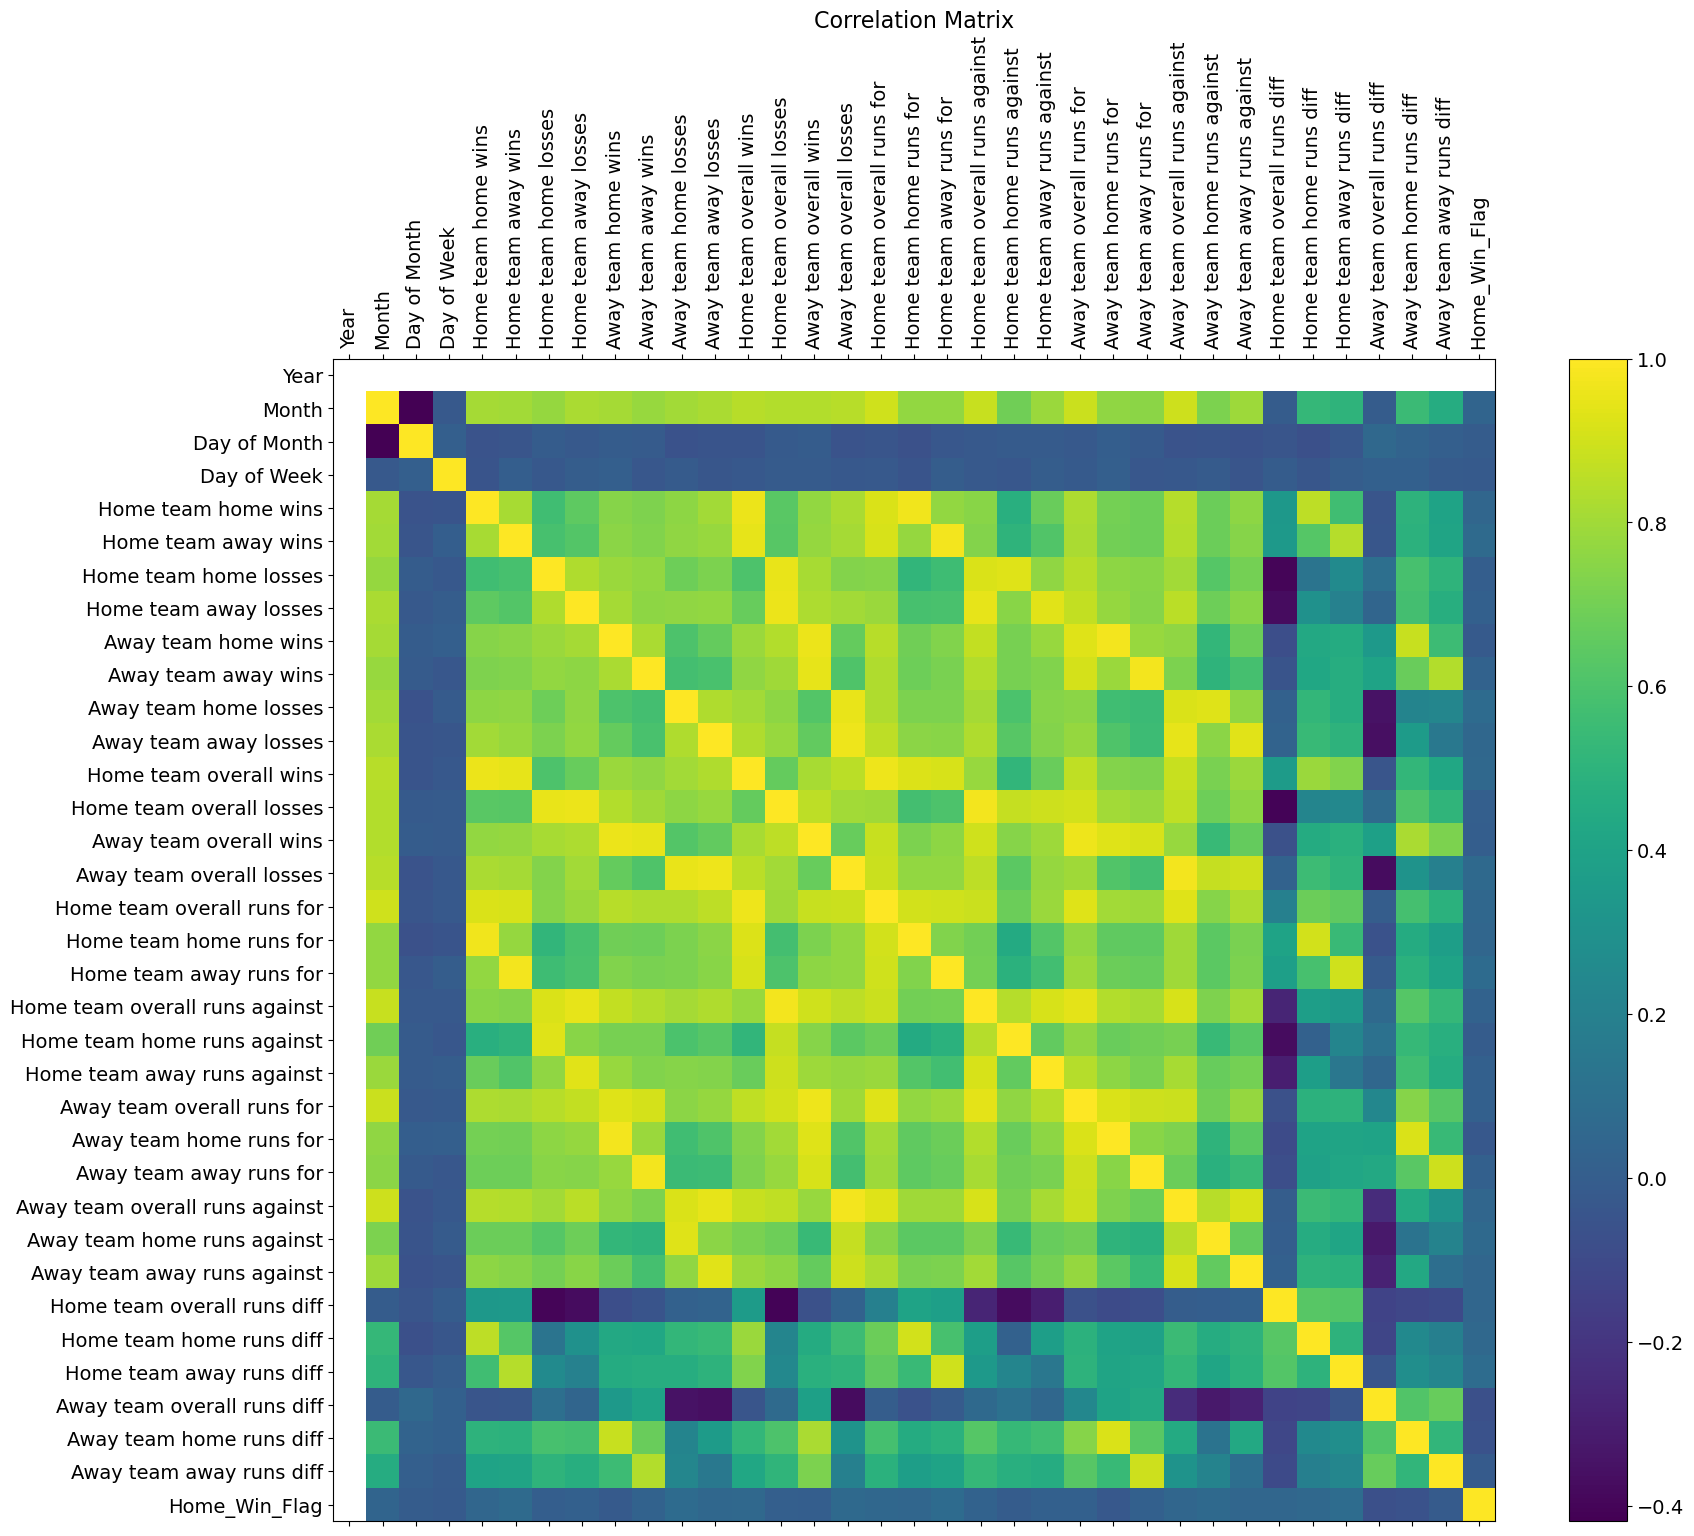

In [33]:
#plot correlation heatmap
plot_data = game_data.drop(['Home Team', 'Away Team'], axis = 1)
f = plt.figure(figsize=(19, 15))
plt.matshow(plot_data.corr(), fignum=f.number)
plt.xticks(range(plot_data.select_dtypes(['number']).shape[1]), plot_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(plot_data.select_dtypes(['number']).shape[1]), plot_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#nothing is even remotely correlated with the home win flag

In [13]:
#Here is where I need to start feeding in predictions.

def record_for_pred(away_team, home_team, date_string = date.today()):
    string_date = date_string.strftime('%Y%m%d')
    pred_dict = {'Year': int(string_date[:4]) #first four digits
        , 'Month': int(string_date[4:6]) #next two digits
        , 'Day of Month': int(string_date[6:8])#next two digits
        , 'Day of Week': day_name_to_num[date_string.strftime('%A')]
        , 'Home Team_' + home_team: 1 #flag
        , 'Away Team_' + away_team: 1 #flag         
        , 'Home team home wins' : team_dict[home_team]['home']['record']['good'] #
        , 'Home team away wins' : team_dict[home_team]['away']['record']['good'] #
        , 'Home team home losses' : team_dict[home_team]['home']['record']['bad'] #
        , 'Home team away losses' : team_dict[home_team]['away']['record']['bad'] #
        , 'Away team home wins' : team_dict[away_team]['home']['record']['good'] #
        , 'Away team away wins' : team_dict[away_team]['away']['record']['good'] #
        , 'Away team home losses' : team_dict[away_team]['home']['record']['bad'] #
        , 'Away team away losses' : team_dict[away_team]['away']['record']['bad'] #  
        , 'Home team overall wins' : team_dict[home_team]['overall']['record']['good'] #
        , 'Home team overall losses' : team_dict[home_team]['overall']['record']['bad'] #
        , 'Away team overall wins' : team_dict[away_team]['overall']['record']['good'] #
        , 'Away team overall losses' : team_dict[away_team]['overall']['record']['bad'] #
        , 'Home team overall runs for' : team_dict[home_team]['overall']['runs']['good'] #
        , 'Home team home runs for' : team_dict[home_team]['home']['runs']['good'] #
        , 'Home team away runs for' : team_dict[home_team]['away']['runs']['good'] #
        , 'Home team overall runs against' : team_dict[home_team]['overall']['runs']['bad'] #
        , 'Home team home runs against' : team_dict[home_team]['home']['runs']['bad'] #
        , 'Home team away runs against' : team_dict[home_team]['away']['runs']['bad'] #
        , 'Away team overall runs for' : team_dict[away_team]['overall']['runs']['good'] #
        , 'Away team home runs for' : team_dict[away_team]['home']['runs']['good'] #
        , 'Away team away runs for' : team_dict[away_team]['away']['runs']['good'] #
        , 'Away team overall runs against' : team_dict[away_team]['overall']['runs']['bad'] #
        , 'Away team home runs against' : team_dict[away_team]['home']['runs']['bad'] #
        , 'Away team away runs against' : team_dict[away_team]['away']['runs']['bad'] #
        , 'Home team overall runs diff' : team_dict[home_team]['overall']['runs']['good'] - team_dict[home_team]['overall']['runs']['bad']#, 'Home team overall runs diff'
        , 'Home team home runs diff' : team_dict[home_team]['home']['runs']['good'] - team_dict[home_team]['home']['runs']['bad']#, 'Home team home runs diff'
        , 'Home team away runs diff' : team_dict[home_team]['away']['runs']['good'] - team_dict[home_team]['away']['runs']['bad']#, 'Home team away runs diff'
        , 'Away team overall runs diff' : team_dict[away_team]['overall']['runs']['good'] - team_dict[away_team]['overall']['runs']['bad']#, 'Away team overall runs diff'
        , 'Away team home runs diff' : team_dict[away_team]['home']['runs']['good'] - team_dict[away_team]['home']['runs']['bad']#, 'Away team home runs diff'
        , 'Away team away runs diff' : team_dict[away_team]['away']['runs']['good'] - team_dict[away_team]['away']['runs']['bad']#, 'Away team away runs diff'
    }
    return pred_dict

In [12]:
#Set up the input games for prediction
intermediate_df = pd.DataFrame(columns = game_data_ohe.columns)
df_for_preds = pd.DataFrame(columns = game_data_ohe.columns)
games_list = [
    ['BAL', 'TOR']
    , ['KC', 'CLE']
    , ['SEA', 'OAK']
    , ['LAD', 'PIT']
    , ['ATL', 'WSH']
    , ['MIN', 'NYY']
    , ['CHC', 'CIN']
    , ['COL', 'STL']
    , ['BOS', 'CHW']
    , ['ARI', 'SD']
]

#generate the records insert for predictions
for i, game in enumerate(games_list):

    #parse the incoming list
    away_team = game[0]
    home_team = game[1]

    new_record = record_for_pred(away_team, home_team)
    intermediate_df = pd.concat([intermediate_df, pd.DataFrame(new_record, index = [i])])

df_for_preds = pd.concat([df_for_preds, intermediate_df])
df_for_preds = df_for_preds.astype(float).fillna(0).astype(int).drop('Home_Win_Flag', axis = 1)
print(df_for_preds)

   Year  Month  Day of Month  Day of Week  Home team home wins  \
0  2024      6             6            5                   15   
1  2024      6             6            5                   21   
2  2024      6             6            5                   14   
3  2024      6             6            5                   14   
4  2024      6             6            5                   10   
5  2024      6             6            5                   20   
6  2024      6             6            5                   14   
7  2024      6             6            5                   12   
8  2024      6             6            5                   10   
9  2024      6             6            5                   13   

   Home team away wins  Home team home losses  Home team away losses  \
0                   14                     15                     17   
1                   19                      7                     13   
2                   11                     17            

In [13]:
a = game_data_ohe.copy().columns
b = df_for_preds.copy().columns
print(len(a))
print(len(b))
df_for_preds[a.difference(b)] = 0 #add the missing columns
df_for_preds = df_for_preds.copy()
game_data_ohe[b.difference(a)] = 0 #add the missing columns
game_data_ohe = game_data_ohe.copy()
print(game_data_ohe.shape) #will eventually split off the home win flag column
print(df_for_preds.shape) #have to remove the home win flag column to do predictions

29
28


In [14]:
#set up the training data, the training labels, and the data to use for predictions
#x_train = game_data.drop('Home_Win_Flag', axis = 1)
#print(x_train.shape)
#y_train = game_data['Home_Win_Flag']
#print(y_train.shape)

#new_df_for_preds = df_for_preds.drop('Home_Win_Flag', axis = 1)
#print(df_for_preds.shape)

#df_for_preds.shape[1] should equal x_train.shape[1]

margin = 30
x_train = game_data_ohe[:-margin].drop('Home_Win_Flag', axis = 1)
y_train = game_data_ohe[:-margin]['Home_Win_Flag']
x_test = game_data_ohe[-margin:].drop('Home_Win_Flag', axis = 1)
y_test = game_data_ohe[-margin:]['Home_Win_Flag']


In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(970, 94)
(970,)
(30, 94)
(30,)


In [16]:
#random forest classifier
mlb_rf1 = RandomForestClassifier(n_estimators = 1000, n_jobs = -2, random_state = 42) #no hyperparameter testing or tuning
mlb_rf1.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-2, random_state=42)

In [17]:
#check that all the columns are in the same order
#print((x_train.columns != df_for_preds.columns).sum())
#should come out to 0 if x_train and df_for_preds have the same column layout

In [18]:
# K-Fold Cross validation
k = 10
print (np.mean(cross_val_score(mlb_rf1, x_train, y_train, cv=k)))
#47% with run differential

0.4701030927835051


In [19]:
#y_pred = mlb_rf1.predict(df_for_preds)
y_pred = mlb_rf1.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
print(mlb_rf1.score(x_test, y_test))
print(y_pred)
#46.67 percent with run differential

[[8 7]
 [9 6]]
0.4666666666666667
[0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0]


In [32]:
for i, game in enumerate(games_list):
    #need to map 0 to 0 (away) and 1 to 1 (home)
    print(game[y_pred[i]]) #use i in y_pred to find Home_Win_Flag prediction.

TOR
CLE
OAK
LAD
WSH
NYY
CIN
COL
CHW
SD


In [33]:
#That's exactly the same prediction as without runs scored
#I need to start trying other classifiers and hypertuning parameters

In [23]:
#xgboost
xgbc = xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', eval_metric = 'auc', tree_method='hist', n_jobs = -2)

xgbc.fit(x_train, y_train)

model = xgbc.get_booster()

In [24]:
# K-Fold Cross validation
k = 10
print (np.mean(cross_val_score(xgbc, x_train, y_train, cv=k)))
#42 percent with run diff at 2000 estimators. 43% with 1000 estimators

0.43092783505154636


In [ ]:
dmat_for_preds = xgb.DMatrix(df_for_preds)
y_pred = model.predict(dmat_for_preds)
z_pred = y_pred >= .5
a_pred = [int(val) for val in z_pred]
for i, game in enumerate(games_list):
    #need to map 0 to 0 (away) and 1 to 1 (home)
    print(game[a_pred[i]]) #use i in y_pred to find Home_Win_Flag prediction.